In [ ]:
import yfinance as yf
import pandas as pd

ticker_symbol = 'AAPL'
start_date = '2015-01-01'
end_date = '2025-01-01'

data = yf.download(ticker_symbol, start=start_date, end=end_date)

print("Columns in the downloaded data:", data.columns)

/var/folders/4f/wdty282j51ddljklq5t8rkc00000gn/T/ipykernel_57177/1005794152.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Columns in the downloaded data: MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

data = data.xs('Close', level='Price', axis=1)

print("Shape of data after selecting 'Close' column:", data.shape)
print("Data head after selection:\n", data.head())

dataset = data.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

training_data_len = int(np.ceil(len(scaled_data) * .8))
train_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Shape of data after selecting 'Close' column: (2516, 1)
Data head after selection:
 Ticker           AAPL
Date                 
2015-01-02  24.288580
2015-01-05  23.604334
2015-01-06  23.606550
2015-01-07  23.937571
2015-01-08  24.857306


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=1, epochs=1)

/Users/kushalsathyanarayan/Desktop/projects/AIML/stock-market-prediction/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1953/1953 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - loss: 8.9521e-04


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/var/folders/4f/wdty282j51ddljklq5t8rkc00000gn/T/ipykernel_57177/2724664508.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid.loc[:, 'Predictions'] = predictions


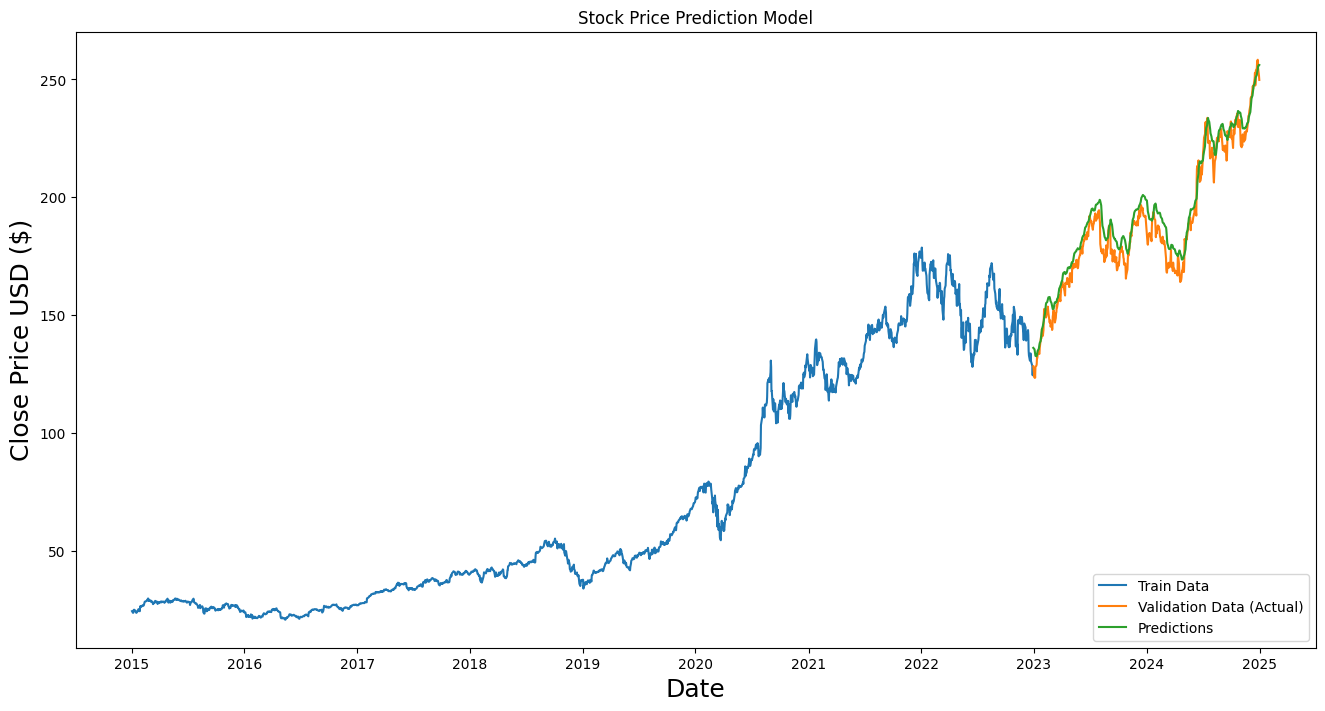

In [ ]:
import matplotlib.pyplot as plt

test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :] 

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) 

train = data.loc[:data.index[training_data_len-1]]
valid = data.loc[data.index[training_data_len]:]

valid.loc[:, 'Predictions'] = predictions

train = train.rename(columns={'AAPL': 'Close'})
valid = valid.rename(columns={'AAPL': 'Close'})

plt.figure(figsize=(16, 8))
plt.title('Stock Price Prediction Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close']) 
plt.plot(valid[['Close', 'Predictions']]) 
plt.legend(['Train Data', 'Validation Data (Actual)', 'Predictions'], loc='lower right')
plt.show()